# Udacity Data Scientist Capstone project

## Project Title: Sparkify

### Project Overview

Sparkify is a music streaming service just as Spotify and Pandora.

The data provided is the user log of the service, having demographic info, user activities, timestamps and etc. We try to analyze the log and build a model to identify customers who are highly likely to quit using our service, and thus, send marketing offers to them to prevent them from churning.


# Problem Statement

Create an ML model that predict sparkify customer churn. A customer churns if he/she downgrades to the free tier or cancel his/her subscription altogether.By generating new features that are good predictors of customer churn, we can build a machine learning model to predict which of sparkify current users are likely to churn.


# Metrics to evaluate performance

We have used F1 score to evaluate model performance as the dataset provided is highly imbalanced, i.e. the number of churned users is very small compared to number of active users.

In [56]:
# import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as psqf
import pyspark.sql.types as psqt
from pyspark.ml.feature import VectorAssembler, StandardScaler\

from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.mllib.util import MLUtils

from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from time import time
%matplotlib inline


In [4]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Data Exploration

In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
#Load the  small subset of data

path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [6]:
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [7]:
#Print schema of the dataset

df.printSchema()


root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
#Get/count null values for each column

df_nulls = df.select([psqf.count(psqf.when(psqf.isnull(c), c)).alias(c) for c in df.columns])
df_nulls.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [10]:
# Check whether the page and userid columns has zero null values

df_nulls.select('userId', 'page').show()


+------+----+
|userId|page|
+------+----+
|     0|   0|
+------+----+



In [11]:
# Count number of customers are in free and paid groups 

level_counts= df.groupby('level').agg({'level':'count'}).withColumnRenamed("count(level)", "level_count")
level_counts.show()

+-----+-----------+
|level|level_count|
+-----+-----------+
| free|      58338|
| paid|     228162|
+-----+-----------+



In [11]:
# Get the unique actions performed by customers using page column.

df.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



In [12]:
# Get the number of ouccrance of all the events from page column.

event_counts= df.groupby('page').agg({'page':'count'}).withColumnRenamed("count(page)", "page_count")
event_counts.show()

+--------------------+----------+
|                page|page_count|
+--------------------+----------+
|              Cancel|        52|
|    Submit Downgrade|        63|
|         Thumbs Down|      2546|
|                Home|     14457|
|           Downgrade|      2055|
|         Roll Advert|      3933|
|              Logout|      3226|
|       Save Settings|       310|
|Cancellation Conf...|        52|
|               About|       924|
| Submit Registration|         5|
|            Settings|      1514|
|               Login|      3241|
|            Register|        18|
|     Add to Playlist|      6526|
|          Add Friend|      4277|
|            NextSong|    228108|
|           Thumbs Up|     12551|
|                Help|      1726|
|             Upgrade|       499|
+--------------------+----------+
only showing top 20 rows



In [13]:
# Get more details about the cancel and cancel_confirmation events

cancel_events = df.filter(psqf.col('page').isin(['Cancel','Cancellation Confirmation'])).select(['userID','page', 'firstName', 'lastName','ts', 'auth'])
cancel_events.show(5, False)

+------+-------------------------+---------+--------+-------------+---------+
|userID|page                     |firstName|lastName|ts           |auth     |
+------+-------------------------+---------+--------+-------------+---------+
|18    |Cancel                   |Adriel   |Mendoza |1538943740000|Logged In|
|18    |Cancellation Confirmation|Adriel   |Mendoza |1538943990000|Cancelled|
|32    |Cancel                   |Diego    |Mckee   |1539033031000|Logged In|
|32    |Cancellation Confirmation|Diego    |Mckee   |1539033046000|Cancelled|
|125   |Cancel                   |Mason    |Hart    |1539318918000|Logged In|
+------+-------------------------+---------+--------+-------------+---------+
only showing top 5 rows



In [14]:
# Similar to calncel events, get the downgrade events

downgrade_events = df.filter(psqf.col('page').isin(['Downgrade']))
downgrade_events.select(['userID','page', 'firstName', 'lastName','ts', 'auth']).show(5, False)

+------+---------+---------+--------+-------------+---------+
|userID|page     |firstName|lastName|ts           |auth     |
+------+---------+---------+--------+-------------+---------+
|54    |Downgrade|Alexi    |Warren  |1538354749000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538373286000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538392612000|Logged In|
|131   |Downgrade|Kael     |Baker   |1538393618000|Logged In|
|95    |Downgrade|Faigy    |Howe    |1538393664000|Logged In|
+------+---------+---------+--------+-------------+---------+
only showing top 5 rows



We can now look for the relationship between cancelled and downgrade events.
We can look for how many of the customers who have downgraded have also cancelled thier subscriptions. Get the registration Id's.

In [15]:
cancel_ids  = [vv['userID'] for vv in cancel_events.select('userID').collect()]
print(len(cancel_ids))

104


In [16]:
downgrade_reg_ids = [vv['userID'] for vv in downgrade_events.select('userID').collect()]
print(len(downgrade_reg_ids), len(set(downgrade_reg_ids)))

2055 154


Now let's see which of those who downgraded also cancel thier subscription. by comparing these two sets.

In [17]:
# Get the customers who downgraded also cancel thier subscription
cust_down_cancel = set(cancel_ids).intersection((set(downgrade_reg_ids)))
print('{0:.2f}% of customers who downgraded have also cancelled their subscriptions'.format(
    100*(len(cust_down_cancel))/len(set(downgrade_reg_ids))))

22.73% of customers who downgraded have also cancelled their subscriptions


In [18]:
# Get userId, page and other detals.

df.filter((psqf.col('userID') == list(cust_down_cancel)[0]) &
                  (psqf.col('page').isin(['Downgrade','Cancel']))).select(['userID','page', 'firstName','ts']).show()

+------+---------+---------+-------------+
|userID|     page|firstName|           ts|
+------+---------+---------+-------------+
|   129|Downgrade|    Davis|1538896047000|
|   129|Downgrade|    Davis|1538911363000|
|   129|Downgrade|    Davis|1538923089000|
|   129|Downgrade|    Davis|1539010046000|
|   129|Downgrade|    Davis|1539347207000|
|   129|Downgrade|    Davis|1539362366000|
|   129|Downgrade|    Davis|1539367200000|
|   129|Downgrade|    Davis|1539736068000|
|   129|   Cancel|    Davis|1539736069000|
+------+---------+---------+-------------+



We can convert the timestamp in to a more readable datetime format.

In [19]:

#Define lambda expression to convert timestamp to datetime.

ts_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S'))

# Replace the new format.
df = df.select('*').withColumn('ts_datetime', ts_udf(psqf.col('ts')))



In [20]:
# Get the same report with updated timestamp
df.filter((psqf.col('userID') == list(cust_down_cancel)[0]) &
                  (psqf.col('page').isin(['Downgrade','Cancel', 'Cancellation Confirmation']))).select(['userID','page', 'firstName','ts', 'ts_datetime']).show(20, False)

+------+-------------------------+---------+-------------+-------------------+
|userID|page                     |firstName|ts           |ts_datetime        |
+------+-------------------------+---------+-------------+-------------------+
|129   |Downgrade                |Davis    |1538896047000|2018-10-07 07:07:27|
|129   |Downgrade                |Davis    |1538911363000|2018-10-07 11:22:43|
|129   |Downgrade                |Davis    |1538923089000|2018-10-07 14:38:09|
|129   |Downgrade                |Davis    |1539010046000|2018-10-08 14:47:26|
|129   |Downgrade                |Davis    |1539347207000|2018-10-12 12:26:47|
|129   |Downgrade                |Davis    |1539362366000|2018-10-12 16:39:26|
|129   |Downgrade                |Davis    |1539367200000|2018-10-12 18:00:00|
|129   |Downgrade                |Davis    |1539736068000|2018-10-17 00:27:48|
|129   |Cancel                   |Davis    |1539736069000|2018-10-17 00:27:49|
|129   |Cancellation Confirmation|Davis    |15397361

## Define churn

From the above data exploration, we can see that cancel is followed by a cancellation confirmation event. Both are indicators of a user is cancelling his subscription. we are going to use both these events for defining the churn

In [21]:
# Define 1 as churned, 0 otherwise

churn_event = df.groupby('userId').agg(psqf.collect_list('page').alias('pages'))
churn_f = psqf.udf(lambda x: 1 if 'Cancel' in set(x) else 0)
churn_event = churn_event.withColumn("label", churn_f(churn_event.pages)).drop('pages')

In [22]:
churn_event.show(3)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
+------+-----+
only showing top 3 rows



### Analyse active users and churned users based on parameters

Lets compare the churned users and the users who stayed back. We can analyse by comparing the action they performed during a specific period of time.



In [23]:
labeled_df  = churn_event.join(df, 'userId')
labeled_df.filter(psqf.col('page').isin(["Cancel", "Cancellation Confirmation"])).select('userId', 'page', 'label').show(5)

+------+--------------------+-----+
|userId|                page|label|
+------+--------------------+-----+
|   125|              Cancel|    1|
|   125|Cancellation Conf...|    1|
|    51|              Cancel|    1|
|    51|Cancellation Conf...|    1|
|    54|              Cancel|    1|
+------+--------------------+-----+
only showing top 5 rows



In [24]:
churned_count = labeled_df.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    0|241636|
|    1| 44864|
+-----+------+



In [25]:
# Lets compare songs played by churned users vs active users
songsplayed = labeled_df.where(psqf.col('song')!='null').groupby("label").agg(psqf.count(psqf.col('song')).alias('SongsPlayed'))
songsplayed.show(5)

+-----+-----------+
|label|SongsPlayed|
+-----+-----------+
|    0|     191714|
|    1|      36394|
+-----+-----------+



In [26]:
# Compare number of dislikes for churned vs active users
thumbsdown_count = labeled_df.where((psqf.col("page")=='Thumbs Down')).groupby("label").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount'))
thumbsdown_count.show(5)

+-----+---------------+
|label|thumbsDownCount|
+-----+---------------+
|    0|           2050|
|    1|            496|
+-----+---------------+



In [27]:
# Compare number of songs liked for churned vs active users
thumbsup_count = labeled_df.where((psqf.col('page')=='Thumbs Up')).groupby("label").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount'))
thumbsup_count.show(5, False)

+-----+-------------+
|label|thumbsUpCount|
+-----+-------------+
|0    |10692        |
|1    |1859         |
+-----+-------------+



In [28]:
# Compare number of downgrades for churned vs active users
downgrade_count = labeled_df.where((psqf.col("page")=='Downgrade')).groupby("label").agg(psqf.count(psqf.col('page')).alias('downgradeCount'))
downgrade_count.show(5)

+-----+--------------+
|label|downgradeCount|
+-----+--------------+
|    0|          1718|
|    1|           337|
+-----+--------------+



# Visualization of results

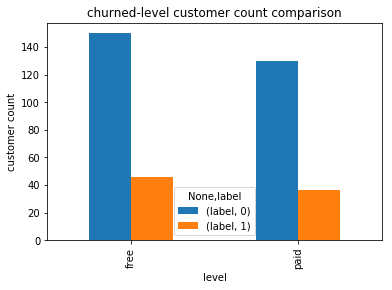

In [29]:
use_level_count = labeled_df.groupby('userId', 'level', 'label').count()
use_level_count_pd  = use_level_count.select("userId", "level", 'label').toPandas()
use_level_count_pd[['level', 'label']].groupby(['level', 'label']).agg({'label':'count'}).unstack().plot(kind='bar');
plt.title('churned-level customer count comparison')
plt.ylabel('customer count');

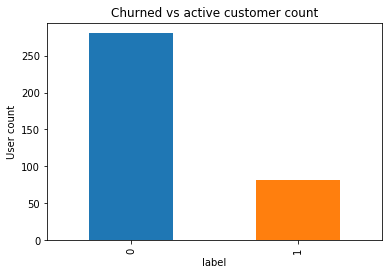

In [23]:
use_level_count_pd.label.value_counts().plot(kind='bar');
plt.ylabel('User count')
plt.xlabel('label')
plt.title('Churned vs active customer count');

# Data Preprocessing

Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features used for defining churn

    1. ts - We can get information about number of hours a customer played songs
    2. page  - Number of thumsUp, downgrades, etc...
    3. song - Number of songs a customer played

In [30]:
# Number of distinct hour counts a user logged in the system
def hour_count():
    hours_udf = psqf.udf(lambda x: datetime.datetime.utcfromtimestamp(x/1000.0).strftime('%Y-%m-%d-%H'))
    hours_df  = labeled_df.select('userId', 'ts').withColumn('hour', hours_udf(psqf.col('ts')))
    hour_count_df = hours_df.where(psqf.col('userId')!='null').groupby('userId').agg((psqf.countDistinct(psqf.col('hour'))).alias("HourCount")).orderBy('userId')
    return hour_count_df


In [31]:
hour_count_df = hour_count()
hour_count_df.show(5)

+------+---------+
|userId|HourCount|
+------+---------+
|      |     1306|
|    10|       51|
|   100|      218|
|100001|       14|
|100002|       18|
+------+---------+
only showing top 5 rows



In [32]:
# Get number of songs each user played
def songs_count():
    songsplayed = labeled_df.where(psqf.col('song')!='null').groupby("userId").agg(psqf.count(psqf.col('song')).alias('SongsPlayed')).orderBy('userId')
    return songsplayed
    


In [33]:
songsplayed = songs_count()
songsplayed.show(5)

+------+-----------+
|userId|SongsPlayed|
+------+-----------+
|    10|        673|
|   100|       2682|
|100001|        133|
|100002|        195|
|100003|         51|
+------+-----------+
only showing top 5 rows



In [34]:
labeled_df = labeled_df.where(psqf.col('userId')!='null') 

In [35]:
# Get Thumbs up and Tgumbs down count

def get_counts():       
    thumbsup_count = labeled_df.where((psqf.col('page')=='Thumbs Up') &(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsUpCount')).orderBy('userId')
    thumbsdown_count = labeled_df.where((psqf.col("page")=='Thumbs Down')&(psqf.col('userId')!='null')).groupby("userId").agg(psqf.count(psqf.col('page')).alias('thumbsDownCount')).orderBy('userId')
    return thumbsup_count, thumbsdown_count

In [36]:
thumbsup_count, thumbsdown_count = get_counts()
thumbsup_count.show(5, False)
thumbsdown_count.show(5)

+------+-------------+
|userId|thumbsUpCount|
+------+-------------+
|10    |37           |
|100   |148          |
|100001|8            |
|100002|5            |
|100003|3            |
+------+-------------+
only showing top 5 rows

+------+---------------+
|userId|thumbsDownCount|
+------+---------------+
|    10|              4|
|   100|             27|
|100001|              2|
|100004|             11|
|100005|              3|
+------+---------------+
only showing top 5 rows



In [37]:
## Join all the features to define the churn event

features_df = churn_event.join(songsplayed, "userId").\
join(hour_count_df, "userId").join(thumbsup_count, "userId").join(thumbsdown_count, "userId")
features_df.show(5)

+------+-----+-----------+---------+-------------+---------------+
|userId|label|SongsPlayed|HourCount|thumbsUpCount|thumbsDownCount|
+------+-----+-----------+---------+-------------+---------------+
|100010|    0|        275|       26|           17|              5|
|200002|    0|        387|       32|           21|              6|
|   124|    0|       4079|      306|          171|             41|
|    51|    1|       2111|      156|          100|             21|
|     7|    0|        150|       18|            7|              1|
+------+-----+-----------+---------+-------------+---------------+
only showing top 5 rows



In [38]:
# Create an assembler from these selected features
assembler = VectorAssembler(inputCols=["SongsPlayed", "HourCount", "thumbsUpCount", "thumbsDownCount"], outputCol="rawFeatures")
features_df = assembler.transform(features_df)
features_df.select('label', 'rawFeatures').show(4)

+-----+--------------------+
|label|         rawFeatures|
+-----+--------------------+
|    0|[275.0,26.0,17.0,...|
|    0|[387.0,32.0,21.0,...|
|    0|[4079.0,306.0,171...|
|    1|[2111.0,156.0,100...|
+-----+--------------------+
only showing top 4 rows



In [39]:
# Define a scalar and fit the features.

scaler = StandardScaler(inputCol="rawFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(features_df)
features_df = scalerModel.transform(features_df)

In [40]:
input_data = features_df.withColumn('label', psqf.col('label').cast(psqt.IntegerType())).select('label', 'features')
input_data.show(2)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[0.24639992057147...|
|    0|[0.34675188822240...|
+-----+--------------------+
only showing top 2 rows



# Implementation

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

##### split datest into train, validation and test sets
    1. Train model using training dataset
    2. Tune model using validation dataset
    3. Test best model based on validation dataset on test dataset.

In [44]:
# Index labels, adding metadata to the label column.

labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(input_data)

# Automatically identify categorical features, and index them.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(input_data)

#### Split the data into training and test sets

In [45]:
# Split the data into training and test sets 
(trainingData, tempData) = input_data.randomSplit([0.6, 0.4])
(validationData, testData) = tempData.randomSplit([0.5, 0.5])

### Random Forest Classifier

In [46]:
def get_pipeline():
    # Train a RandomForest model.
    rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)
    # Convert indexed labels back to original labels.
    labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                                   labels=labelIndexer.labels)
    # Chain indexers and forest in a Pipeline
    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
    return pipeline, labelConverter

In [47]:
# Train model. 
pipeline, labelConverter = get_pipeline()
model = pipeline.fit(trainingData)

In [48]:
# Make predictions.
predictions = model.transform(validationData)
predictions.select("predictedLabel", "label", "features").show(5)


+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[1.72748744313385...|
|             0|    0|[1.00799967506513...|
|             1|    1|[0.33779189111071...|
|             0|    1|[1.30547157917325...|
|             0|    0|[3.23993495558715...|
+--------------+-----+--------------------+
only showing top 5 rows



In [49]:
# Evaluate the model
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Validation Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)

Validation Error = 0.263158
RandomForestClassificationModel (uid=RandomForestClassifier_27b98c79706e) with 10 trees


In [50]:
# Get F1 score and evaluate

f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
f1_score = f1_score_evaluator.evaluate(predictions)
print("F1 score = %g" % (f1_score))

F1 score = 0.66408



### Logistic Regression

In [57]:
# initialize classifier
def logistic_regression():    
    lr = LogisticRegression(maxIter=10)

    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

    paramGrid = ParamGridBuilder() \
        .build()

    crossval_lr = CrossValidator(estimator=lr,
                              evaluator=f1_evaluator, 
                              estimatorParamMaps=paramGrid,
                              numFolds=3)
    return crossval_lr

In [58]:
crossval_lr = logistic_regression()

start = time()
cvModel_lr = crossval_lr.fit(trainingData)
end = time()
cvModel_lr.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 694.3865914344788 seconds


In [59]:
results_lr = cvModel_lr.transform(validationData)

In [60]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.6842105263157895
F-1 Score:0.6263157894736844


### Support Vector Machine

In [61]:
# Support Vector machine model

def svm():

    svm = LinearSVC(maxIter=10)

    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

    paramGrid = ParamGridBuilder() \
        .build()

    crossval_svm = CrossValidator(estimator=svm,
                              estimatorParamMaps=paramGrid,
                              evaluator=f1_evaluator,
                              numFolds=3)
    return crossval_svm

In [62]:
crossval_svm = svm()

start = time()
cvModel_svm = crossval_svm.fit(trainingData)
end = time()
cvModel_svm.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 734.9559786319733 seconds


In [63]:
results_svm = cvModel_svm.transform(validationData)

In [64]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.6842105263157895
F-1 Score:0.5559210526315791


#### Model summary

The logistic regression model has a accuracy of: 0.684 and F-1 Score:0.626

The Support vector machine model has a accuracy of: 0.684, and F1 score of: 0.555

The Random forest model has a accuracy of: 0.776, and F1 score of: 0.66408

we will prefer the model that perform the best. Therefore, we choose Random Forest Classifier model as our final model and conduct a grid search to fine tune our model this time.


# Fine tuning  / Refinement

We use grid search to fine tune our Random Foresr Classifier. We mainly tuned two parameters, maxDepth and numTrees.

In [66]:
def new_model():
    rfc = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

    # Chain indexers and forest in a Pipeline

    pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rfc, labelConverter])
    param_grid = ParamGridBuilder().addGrid(rfc.numTrees, [10, 15]).addGrid(rfc.maxDepth, [2, 5]).build()
    cv = CrossValidator(estimator=pipeline, 
                        estimatorParamMaps = param_grid, 
                        evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                        numFolds=3)    
    return cv

In [67]:
cv = new_model()
best_model = cv.fit(trainingData)

In [68]:
# Method to evaluate our model

def evaluation(model, data):
    """
    Make prediction and evaluate model.
    Parameters
    -----------
        model: model object
    returns
    -------
        None
    """
    predictions = model.transform(data)
    
    predictions.select("predictedLabel", "label", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    print("Error = %g" % (1.0 - accuracy))
    f1_score_evaluator = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction",metricName='f1')
    f1_score = f1_score_evaluator.evaluate(predictions)
    print("F1 score = %g" % (f1_score))

In [69]:
# On validation set 
evaluation(model=best_model, data=validationData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[1.72748744313385...|
|             0|    0|[1.00799967506513...|
|             1|    1|[0.33779189111071...|
|             0|    1|[1.30547157917325...|
|             0|    0|[3.23993495558715...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.315789
F1 score = 0.596895


In [70]:
# On Test data
evaluation(model=best_model, data=testData)

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|             0|    0|[0.24639992057147...|
|             0|    1|[1.89145539027778...|
|             0|    1|[0.23027192577043...|
|             0|    0|[0.19263993790133...|
|             1|    0|[0.21235193154705...|
+--------------+-----+--------------------+
only showing top 5 rows

Error = 0.272727
F1 score = 0.679888


# Results

We have analysed the sparkify dataset and come up with new features to predict churn. We then created a machine learning model and tuned it to improve its performance. We achieved an accuracy score of 77% and F1 score of 0.679888 on the test dataset.

We use grid search to fine tune our Random Foresr Classifier. We mainly tuned two parameters, maxDepth and numTrees. 

# Conclusion

In this project, we have implemented a model trying to predict customer churn. We have done all the pre processing required for the data like removed rows with no userId, converted timestamp to a human readable format, converted gender to binary numeric column. 

We have selected different features to define our churn. We selected 3 models: logistic regression,  SVM, and RF to compare and selected Random Forest as the final model implemented for predicting final result. 

We used cross validation and grid search to fine tune our model. We achieved about 77% accuracy, and 0.679888 F1 score.

# Future Improvements

The model peformance can be further improved by creating additional features and includiding some of the features that we have left out for this analysis. The model should be tested out against the bigger data set for more accuracy. We can also try to test with multiple models and with multiple model parameters and picks the best fitted algorithm for the model. For our analysis we picked up RFandom Forest Classifier as that seems the best approach for thios data set.
